# Introduction to Huggingface 🤗

Huggingface is an open source data science and machine learning platform for AI builders. It has a lot of useful libraries which can abstract a significant amount of source code and allow efficient usage of artifacts like datasets, models, evaluation metrics, etc.

In addition to libraries, it also provides Hub and Spaces which are collaboration platform and an interactive GUI respectively. 

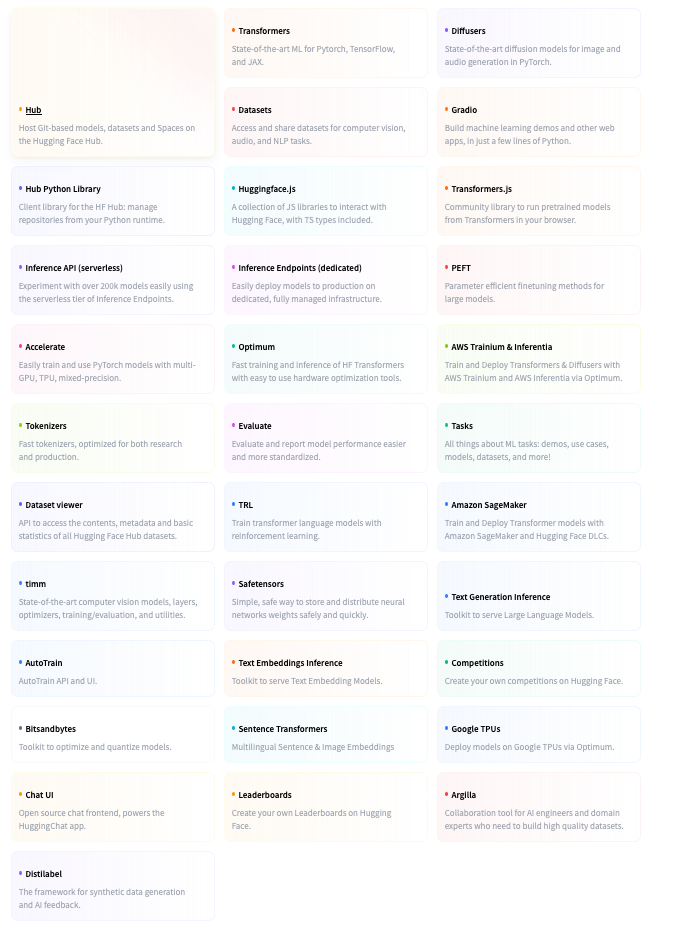

We will be focusing only on some key functionalities of useful libraries of Huggingface with Pytorch implementation of artifacts, which are outlined as follows -
1. Datasets
2. Transformers
3. Evaluate
4. Examples

Some other key libraries for NLP tasks that you can explore - Tokenizers, Sentence Transformers, PEFT, Diffusers, Bitsandbytes, Safetensors, Accelerate

Assignments will mostly not involve Huggingface. This will be more helpful for projects where you can focus on research ideas without getting into the abstractions of base implementation of models.

In [1]:
cache_dir = './huggingface_cache'

**Disclaimer:**

This tutorial is designed to introduce you to HuggingFace's tools, including datasets, transformers, and the evaluate library, in NLP workflows. The focus here is on practical implementation rather than in-depth explanations of the underlying concepts. While concepts are not covered in this tutorial, rest assured that they will be thoroughly explained in lectures. Even if you don't fully understand everything at this stage, this tutorial will still be valuable for your exposure, your projects, and will serve as a helpful reference when revisiting how to implement these concepts after they've been covered in class. Through the course, you'll gain a full conceptual grasp of the models and techniques used, and you can come back to this notebook to see just how to implement them using HuggingFace.

## 1. Datasets

The Huggingface Datasets library is an open-source Python library designed to simplify the process of accessing, managing, and processing a wide range of datasets. The library is optimized for performance, allowing users to load, filter, and transform datasets efficiently, even when working with large-scale data.

Datasets can be accessed with just a few lines of code, and the library handles tasks like downloading, caching, and versioning automatically. The library includes powerful tools for data processing, allowing users to easily manipulate and transform datasets. This includes tasks like filtering, shuffling, splitting, and mapping functions over dataset elements.

Docs: https://huggingface.co/docs/datasets

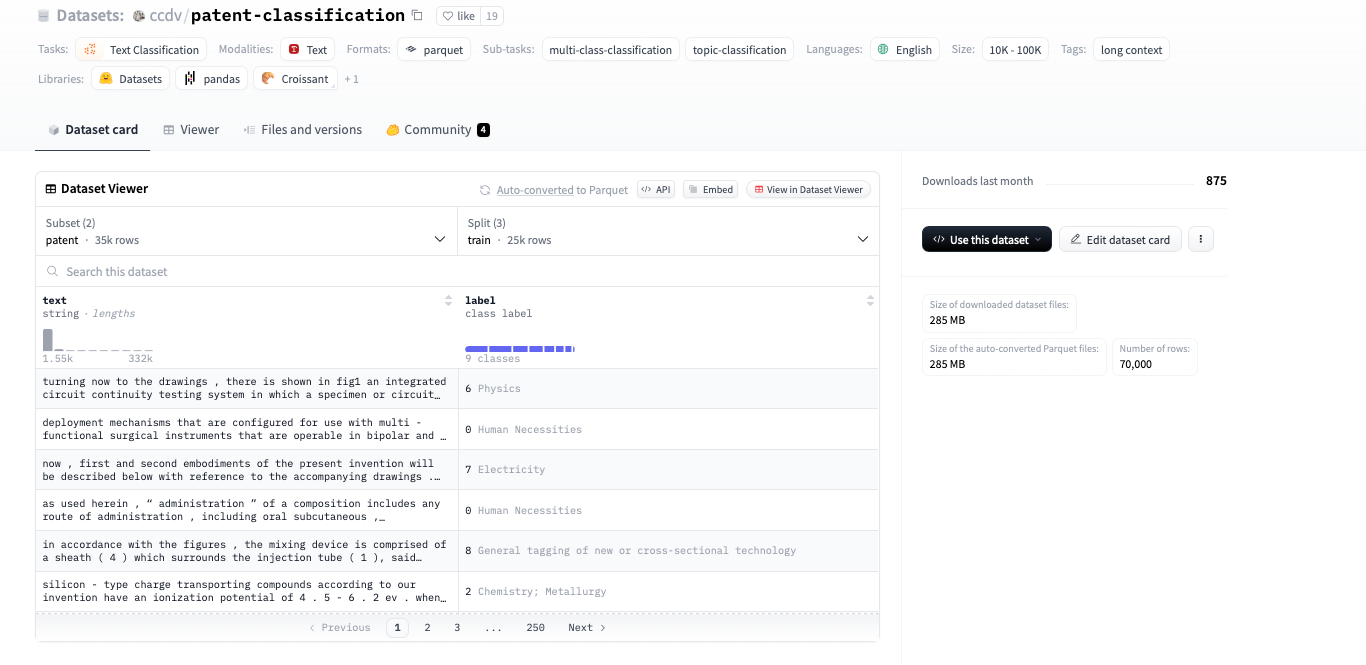

In [8]:
# !pip install datasets

In [9]:
from datasets import load_dataset

In [10]:
dataset = load_dataset('ccdv/patent-classification', cache_dir=cache_dir)

#### Suggestions

If you don't specify a cache directory, all files will be downloaded to your conda environment's root, drastically increasing it size. Specifying a cache_dir is very helpful, particularly in distributed environments, as you can control the location where these large datasets (and models) are stored, without impacting your environment.

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [12]:
dataset_train = load_dataset('ccdv/patent-classification', cache_dir=cache_dir, split='train')

In [13]:
dataset_train

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [39]:
print('Text -', dataset_train[0]['text'][0:300], '...(continued)') # trimmed for brevity
print('Label -', dataset_train[0]['label'])

Text - turning now to the drawings , there is shown in fig1 an integrated circuit continuity testing system in which a specimen or circuit configuration 16 is mounted on a fixture 18 operable to vibrate the specimen under controlled conditions , e . g . sinusoidally , randomly , or a combination of the two ...(continued)
Label - 6


In [ ]:
# Get all the labels directly
label_info = dataset['train'].features['label']
print(label_info)

In [ ]:
# Get a mapping of label index to name and vice-versa
id2label = {i: label for i, label in enumerate(label_info.names)}
label2id = {label: i for i, label in enumerate(label_info.names)}

print("id2label:", id2label)
print("label2id:", label2id)

In [40]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset_train, batch_size=10, shuffle=True)
# can add a custom sampler, distributed sampler, etc., like with a standard torch dataloader

In [41]:
for idx, batch in enumerate (data_loader):
    print(f'\nShowing Batch {idx} of {len(data_loader)}')
    print('Data type -',type(batch))
    print('Keys -',batch.keys())
    print('Batch labels -',batch['label']) # only displaying the label for brevity
    print('Device -', batch['label'].device)
    print('Moving tensor to GPU')
    batch['label'] = batch['label'].to(device='mps') # device='cuda' for Nvidia GPUs (not an in-place operation)
    print('Device after changing -', batch['label'].device)
    print('\n----------END OF BATCH----------')
    if idx >= 3:
        break # to break the loop as it is there only for demonstration


Showing Batch 0 of 2500
Data type - <class 'dict'>
Keys - dict_keys(['text', 'label'])
Batch labels - tensor([8, 5, 3, 7, 5, 1, 2, 7, 8, 1])
Device - cpu
Moving tensor to GPU
Device after changing - mps:0

----------END OF BATCH----------

Showing Batch 1 of 2500
Data type - <class 'dict'>
Keys - dict_keys(['text', 'label'])
Batch labels - tensor([7, 8, 2, 7, 5, 6, 1, 8, 7, 7])
Device - cpu
Moving tensor to GPU
Device after changing - mps:0

----------END OF BATCH----------

Showing Batch 2 of 2500
Data type - <class 'dict'>
Keys - dict_keys(['text', 'label'])
Batch labels - tensor([6, 2, 6, 6, 0, 7, 0, 1, 0, 6])
Device - cpu
Moving tensor to GPU
Device after changing - mps:0

----------END OF BATCH----------

Showing Batch 3 of 2500
Data type - <class 'dict'>
Keys - dict_keys(['text', 'label'])
Batch labels - tensor([0, 6, 8, 3, 1, 7, 1, 0, 6, 7])
Device - cpu
Moving tensor to GPU
Device after changing - mps:0

----------END OF BATCH----------


#### Common pitfalls

- Non-numeric data is not automatically converted into tensor by the dataloader. They have to be dealt with separately. As a result, tensor functions also don't work with them.

- .to(device) is not an in-place operation. If it is not assigned to an object, the original object doesn't move to GPU, causing a device mismatch error (if your model is on GPU).

## 2. Transformers

Hugging Face Transformers is an open-source Python library that offers a vast collection of **pre-trained Transformer models** for tasks in natural language processing (NLP), computer vision, audio processing, and more. It streamlines the implementation of Transformer models by handling the complexities of training or deploying models, allowing users to work with higher-level APIs instead of directly using frameworks like PyTorch, TensorFlow, or JAX.



Docs: https://huggingface.co/docs/transformers

You can utilize them directly for application, in a pipeline, or further training/fine-tuning.

Usually, each model has two essential components - tokenizer and model. 


### 2.1. Tokenizers

A tokenizer is in charge of preparing the inputs for a model. The library contains tokenizers for all the models.

Tokenizer API Docs: https://huggingface.co/docs/transformers/main_classes/tokenizer

In [1]:
from transformers import AutoTokenizer

In [5]:
bert_tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity", cache_dir=cache_dir)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [22]:
import random

vocab = bert_tokenizer.get_vocab() # a dictionary of token:index pairs
vocab_keys = list(vocab.keys())
vocab_size = len(vocab)
print('Size of vocabulary=', vocab_size)
print('Some example of key-value pairs:')
for idx in range(20): # display some random examples
    random_index = random.randint(0, vocab_size)
    random_token = vocab_keys[random_index]
    print(random_token,':',vocab[random_token])

Size of vocabulary= 30522
Some example of key-value pairs:
sales : 4341
campeonato : 17675
##onte : 28040
things : 2477
skill : 8066
##پ : 29839
[unused143] : 148
##& : 29617
retro : 22307
##rts : 21217
##iro : 9711
##ryn : 18143
##camp : 26468
immunity : 15403
##hale : 15238
compartment : 15273
[unused371] : 376
304 : 23859
37 : 4261
median : 3991


In [25]:
input_text = 'Hello, welcome to CS 7650 - Natural Language. We hope you have fun.'

In [50]:
tokens = bert_tokenizer(input_text)
print(tokens['input_ids'])
print('Type-', type(tokens['input_ids']))

[101, 7592, 1010, 6160, 2000, 20116, 6146, 12376, 1011, 3019, 2653, 1012, 2057, 3246, 2017, 2031, 4569, 1012, 102]
Type- <class 'list'>


In [33]:
# Let's try to reproduce the string using the tokens. 
# Ideally, you should be able to retrieve the same string if the key-value mapping is correct since this relation is symmetric.
bert_tokenizer.decode(tokens['input_ids'])

'[CLS] hello, welcome to cs 7650 - natural language. we hope you have fun. [SEP]'

#### Every Model Has Its Own Tokenizer

Every model in natural language processing (NLP) typically has its own tokenizer because the tokenizer is tightly coupled with the model's architecture, vocabulary, and training process. The design of the tokenizer affects how the model interprets input text and, consequently, its performance on various tasks. Here's a detailed explanation of why this is the case:

#### 1. Vocabulary Alignment
- **Vocabulary Size**: Different models have different vocabulary sizes, which is the set of tokens (words, subwords, or characters) the model understands. A tokenizer must be designed to align with this specific vocabulary.
- **Predefined Tokens**: Models are trained with specific tokens representing words, subwords, or special tokens like `[CLS]`, `[SEP]`, and `[PAD]`. The tokenizer needs to ensure that the input text is split into these predefined tokens.

#### 2. Handling of Special Tokens
- Models use special tokens to handle different types of inputs, manage sequences, or denote the start and end of sentences. For example:
  - BERT uses `[CLS]` for classification and `[SEP]` to separate sentences.
  - GPT uses `<|endoftext|>` to denote the end of text.
- The tokenizer must insert these tokens correctly in the input text based on how the model was trained.

#### Illustration

Consider BERT and GPT-2

If you used BERT's tokenizer with GPT-2 or vice versa, the models would not interpret the inputs correctly, leading to inaccurate or nonsensical outputs.


In [30]:
from transformers import GPT2Tokenizer

gpt_2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir=cache_dir)

In [31]:
# Decoding back the same sequence of the above string using a GPT-2 tokenizer
gpt_2_tokenizer.decode(tokens['input_ids'])

'�lationtersiency mind Lead ske theoret takezz comput Cl food terrorwards Europe traditional Cl�'

So essentially, using a different tokenizer will entirely confuse the model, as the token ids used would represent something entirely different. This would result in model not learning/inferring the correct thing.

Let's look at this from another angle. Not of the ids that are assigned to each token, but also how the sentence is converted into tokens.

In [42]:
print('Tokens from BERT Tokenizer -', bert_tokenizer.tokenize(input_text))
print('Tokens from GPT2 Tokenizer -', gpt_2_tokenizer.tokenize(input_text))     

Tokens from BERT Tokenizer - ['hello', ',', 'welcome', 'to', 'cs', '76', '##50', '-', 'natural', 'language', '.', 'we', 'hope', 'you', 'have', 'fun', '.']
Tokens from GPT2 Tokenizer - ['Hello', ',', 'Ġwelcome', 'Ġto', 'ĠCS', 'Ġ76', '50', 'Ġ-', 'ĠNatural', 'ĠLanguage', '.', 'ĠWe', 'Ġhope', 'Ġyou', 'Ġhave', 'Ġfun', '.']


In [44]:
print('Tokens IDs from BERT Tokenizer -', bert_tokenizer(input_text)['input_ids'])
print('Tokens IDs from GPT2 Tokenizer -', gpt_2_tokenizer(input_text)['input_ids'])   

Tokens IDs from BERT Tokenizer - [101, 7592, 1010, 6160, 2000, 20116, 6146, 12376, 1011, 3019, 2653, 1012, 2057, 3246, 2017, 2031, 4569, 1012, 102]
Tokens IDs from GPT2 Tokenizer - [15496, 11, 7062, 284, 9429, 8684, 1120, 532, 12068, 15417, 13, 775, 2911, 345, 423, 1257, 13]


So, each tokenizer is different, and tightly coupled with its corresponding model as the model is trained on these indices. Therefore, using the correct tokenizer is important.

#### Tensors, Batching, Padding, Truncation

In [48]:
# Getting torch tensors just requires adding a parameter
tokens = bert_tokenizer(input_text, return_tensors='pt')
# Move to device
tokens = tokens.to(device='mps') # 'cuda' for Nvidia GPUs
print('Type-', type(tokens['input_ids']), 'Device-', tokens['input_ids'].device)

Type- <class 'torch.Tensor'> Device- mps:0


In [54]:
# Can seamlessly handle batches and padding

input_batch = [
    "It does not do to dwell on dreams and forget to live.",
    "Yer a wizard, Harry.",
    "I solemnly swear that I am up to no good.",
    "After all this time? Always.",
    "Happiness can be found, even in the darkest of times, if one only remembers to turn on the light."
]

batch_tokens = bert_tokenizer(input_batch, return_tensors='pt', padding=True)
# Move to device
batch_tokens = batch_tokens.to(device='mps') # 'cuda' for Nvidia GPUs
print('Type-', type(batch_tokens['input_ids']), 'Device-', tokens['input_ids'].device)


Type- <class 'torch.Tensor'> Device- mps:0


In [55]:
bert_tokenizer.batch_decode(batch_tokens['input_ids']) # pads to max length by default

['[CLS] it does not do to dwell on dreams and forget to live. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] yer a wizard, harry. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i solemnly swear that i am up to no good. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] after all this time? always. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] happiness can be found, even in the darkest of times, if one only remembers to turn on the light. [SEP]']

In [60]:
batch_tokens = bert_tokenizer(input_batch, return_tensors='pt', padding=True, truncation=True, max_length=16)
# Move to device
batch_tokens = batch_tokens.to(device='mps') # 'cuda' for Nvidia GPUs
bert_tokenizer.batch_decode(batch_tokens['input_ids'])

['[CLS] it does not do to dwell on dreams and forget to live. [SEP] [PAD]',
 '[CLS] yer a wizard, harry. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i solemnly swear that i am up to no good. [SEP] [PAD] [PAD] [PAD]',
 '[CLS] after all this time? always. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] happiness can be found, even in the darkest of times, if one [SEP]']

You can also build on top of existing tokenizers, and add your own tokens. Refer to the docs for more details.

### 2.2. Models

The Hugging Face transformers library provides access to a wide array of state-of-the-art Transformer models designed for NLP, Vision, Multimodal and other tasks. These models, including BERT, GPT, T5, and many others, are pre-trained on massive datasets and fine-tuned for specific tasks. The library offers a unified API to load, train, and deploy these models, making it easy for users to leverage advanced capabilities without needing to build models from scratch. The advantage of using transformers lies in its extensive model hub, where users can find and share pre-trained models, thus accelerating development and enabling consistent, high-quality performance across various NLP applications.

In [75]:
from transformers import BertForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", cache_dir=cache_dir)
bert_model

/Users/neelabh/anaconda3/envs/nlp_env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

```.from_pretrained()``` method can also be used to import a local checkpoint from cache_dir.

This is now an already trained PyTorch model, everything else that PyTorch supports will be supported with this model, with only one line of code and no pre-training.

#### Model Configuration

Every model has a config file. The model config is a vital component that encapsulates the architecture, behavior, and hyperparameters governing a model's operation. This configuration file includes details such as the number of hidden layers, attention heads, and the dimensionality of hidden states, which define the model's architecture. It also specifies hyperparameters like learning rate, dropout rate, and initialization settings, crucial for training and fine-tuning the model. Additionally, model.config manages task-specific parameters, such as the number of labels for classification tasks and whether to output attention weights or hidden states. Beyond the configuration, understanding Hugging Face models involves grasping key concepts like tokenization, fine-tuning, and the use of pre-trained models across different tasks.

In [76]:
bert_model.config

BertConfig {
  "_name_or_path": "textattack/bert-base-uncased-yelp-polarity",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "yelp_polarity",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### Different Types of BERT (and other models) Available

BERT Docs: https://huggingface.co/docs/transformers/v4.44.2/en/model_doc/bert

Generally, for all models, there will be many types of models available in HuggingFace. For example, BERT has the following -
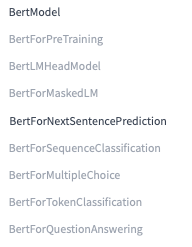

Why?

The reason for having so many variations is that BERT is a versatile model that can be adapted to a wide range of NLP tasks. Each of these variations takes the core BERT architecture and tailors it for a specific task by adding task-specific heads (layers) on top of the base model. This specialization allows users to fine-tune BERT more effectively for the particular needs of their applications, ensuring better performance and more accurate results.

In [79]:
from transformers import BertModel

bert_base = BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir=cache_dir)
bert_base

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

You will find similar variants for GPT2.

Knowing your task, importing the correct model and using it correctly is important. Not doing this won't show any syntax errors, but your outputs/learning won't be correct. 

## 3. Evaluate

The Hugging Face evaluate library is a powerful tool designed to streamline the process of evaluating machine learning models, particularly in the context of natural language processing (NLP). It provides a wide range of standardized evaluation metrics and datasets, allowing users to assess the performance of their models with ease. By abstracting the complexity of metric computation, the evaluate library enables quick integration into model development pipelines, ensuring consistent and reproducible evaluations across different models and tasks. One of its key advantages is its compatibility with the Hugging Face datasets and transformers libraries, making it simple to pair model predictions with appropriate metrics. This integration reduces the overhead of custom evaluation code, promotes best practices in model validation, and facilitates the comparison of models by providing access to a common set of metrics used in the community.

Docs: https://huggingface.co/docs/evaluate

Some supported metrics: https://huggingface.co/evaluate-metric

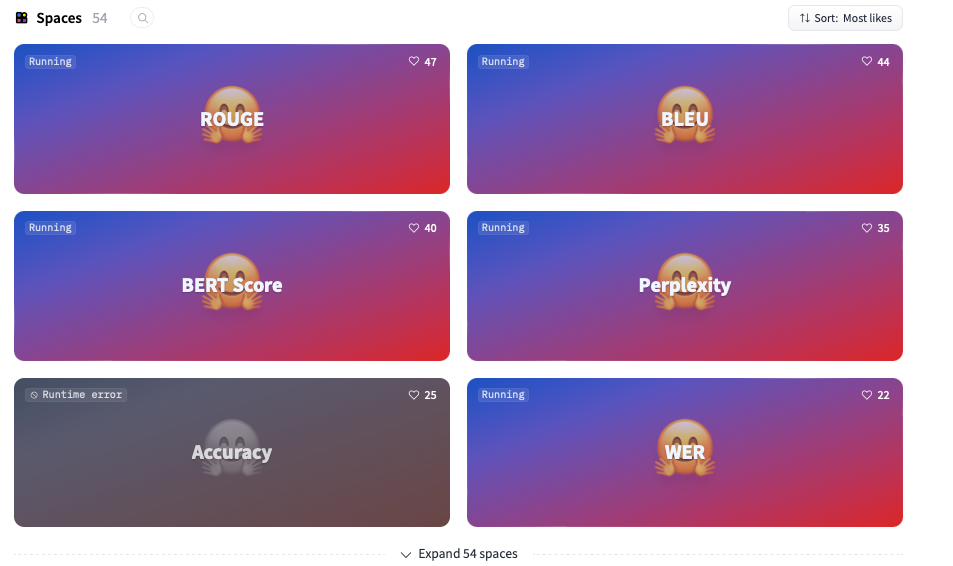

In [6]:
from evaluate import load

rouge = load('rouge', cache_dir=cache_dir)
predictions = [
    "It does not do to dwell on dreams and forget to live.",
    "After all this time? Always."
]
references = [
    "It does not do well to dwell on dreams and forget to live.",
    "After all this time? Yes, always."
]
results = rouge.compute(predictions=predictions, references=references)
print(results)


{'rouge1': 0.9345454545454546, 'rouge2': 0.7681159420289854, 'rougeL': 0.9345454545454546, 'rougeLsum': 0.9345454545454546}


Supports batches and aggregation by default.

This provides other metrics like accuracy, recall, f1-score as well. But where it excels from other libraries is its text generation metrics support, and seamless integration with other Huggingface libraries.

## 4. Examples

We shall now cover two examples - 
1. Finetuning a DistilBERT for Text Classification
2. Text Generation using Gemma-2B (we shall only show inference, but you can also fine-tune it or use it in any other way like a PyTorch model)

### 4.1. Fine-tuning a DistilBERT for Text Classification

Here, we shall integrate all modules discussed above to fine-tune a DistilBERT for Sequence Classification.

DistilBERT is a streamlined, efficient version of the original BERT model, developed by Hugging Face to offer a balance between performance and computational efficiency. With 40% fewer parameters and a 60% faster inference time, DistilBERT achieves about 97% of BERT's performance across various NLP tasks, including text classification and question answering. It is trained using knowledge distillation, where the smaller model learns from the outputs and intermediate representations of a larger, pre-trained BERT model. By reducing the number of layers from 12 to 6 and eliminating the next sentence prediction objective, DistilBERT becomes a practical solution for deploying powerful NLP models in resource-constrained environments, such as mobile devices and real-time applications.

In [2]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from evaluate import load

In [3]:
# The entire code of loading a dataset, creating data loader, creating a tokenizer, defining a large model is reduced to 4 lines
dataset = load_dataset('ccdv/patent-classification', cache_dir=cache_dir)

In [4]:
label_info = dataset['train'].features['label']
id2label = {i: label for i, label in enumerate(label_info.names)}
label2id = {label: i for i, label in enumerate(label_info.names)}

In [5]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", cache_dir=cache_dir)
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id, cache_dir=cache_dir)

/Users/neelabh/anaconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
distilbert_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Now, instead of Tokenizing every batch every epoch, we can use HuggingFace functions to do this seamlessly in one go for the entire dataset.

In [7]:
def preprocess_function(examples):
    return distilbert_tokenizer(examples["text"], truncation=True)
# since we are using the distilbert_tokenizer, this will automatically be truncated to the max length of distilbert

In [8]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [12]:
# Creating a subset only to reduce training time, since this is just for demonstration
from torch.utils.data import Subset

subset_train = Subset(tokenized_dataset['train'], list(range(5000)))
subset_val = Subset(tokenized_dataset['validation'], list(range(500)))

We will now define a **Data collator**.

Data collators are utility classes provided in the transformers library that help prepare batches of data for training or evaluation in a model-friendly format. They handle tasks such as padding sequences to the same length within a batch, dynamically adjusting padding during training, and creating appropriate input formats for specific tasks, such as language modeling or sequence classification.

Docs: https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/data_collator

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=distilbert_tokenizer)

In [11]:
# Defining evaluation metric
import numpy as np


accuracy = load("accuracy", cache_dir=cache_dir)

def accuracy_metric(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Now let's start our training. We can also use the PyTorch training loop as discussed during the PyTorch tutorial (since these models are ultimately PyTorch models). But, let's utilize a more abstract training API provided by HuggingFace.

#### Huggingface Trainer API

The Trainer API is a high-level abstraction that simplifies the process of training, evaluating, and fine-tuning transformer models. It handles many of the complexities of model training, such as data loading, optimization, gradient accumulation, mixed precision training, and more. This document provides an overview of the key components and steps involved in using the Trainer API.

Key Components of the Trainer API:

 - Model: The pre-trained model or custom model you want to fine-tune or train.
- TrainingArguments: A configuration class that specifies the parameters for training, such as learning rate, batch size, number of epochs, and more.
- Datasets: The training and evaluation datasets, which can be in the form of Hugging Face Datasets or PyTorch datasets.
- Data Collator: An optional component that handles data formatting and padding for batches.
- Tokenizer: The tokenizer associated with the model, used for preprocessing text data.
- Compute Metrics: A function for calculating evaluation metrics during validation.

Docs: https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/trainer


Define Training arguments -

Set up the training configuration using TrainingArguments. This configuration class includes various parameters that control the training process, such as:

- output_dir: Directory where the model checkpoints and logs will be saved.
- learning_rate: The learning rate for the optimizer.
- per_device_train_batch_size: The batch size per GPU/TPU core/CPU for training.
- per_device_eval_batch_size: The batch size per GPU/TPU core/CPU for evaluation.
- num_train_epochs: The number of epochs to train the model.
- weight_decay: The weight decay to apply to the optimizer.
- eval_strategy: When to run evaluation (e.g., at each epoch).
- save_strategy: When to save model checkpoints (e.g., at each epoch).
- load_best_model_at_end: Whether to load the best model found during training at the end.
- push_to_hub: Whether to push the model to the Hugging Face Model Hub.
These arguments are crucial for defining how your model will be trained and evaluated.

In [13]:
training_args = TrainingArguments(
    output_dir="./cache_dir/cs7650_tutorial_finetuning_classification",
    learning_rate=2e-5, # use less learning rate with fine-tuning
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, # will automatically load the best model at epoch i after training
    push_to_hub=False, # can push model to Huggingface hub
    report_to='none' # can export results to visualizing tools like wandb
)

After setting up the TrainingArguments, create the Trainer object. The Trainer manages the entire training process and is initialized with the following components:

- Model: The pre-trained model or custom model you want to fine-tune or train.
- Arguments: The TrainingArguments that define the training configuration.
- Datasets: The training and evaluation datasets, which can be from the Hugging Face Datasets library.
- Tokenizer: The tokenizer used to preprocess the text data for the model.
- Data Collator (optional): A function or class that handles data formatting, such as padding sequences to the same length within a batch.
- Compute Metrics (optional): A function that calculates evaluation metrics during validation.

In [14]:
trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=subset_train, # truncating for demonstration
    eval_dataset=subset_val,
    tokenizer=distilbert_tokenizer,
    data_collator=data_collator,
    compute_metrics=accuracy_metric,
)

Now we shall train the model, that only requires a single function call.

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.462300,1.353105,0.522000
2,1.096100,1.269650,0.570000
3,0.942000,1.293074,0.564000


TrainOutput(global_step=1875, training_loss=1.1028857584635416, metrics={'train_runtime': 1035.3251, 'train_samples_per_second': 14.488, 'train_steps_per_second': 1.811, 'total_flos': 1987259028480000.0, 'train_loss': 1.1028857584635416, 'epoch': 3.0})

#### Model Inference

Go and check the folders and files created during training. We can pick any checkpoint from it to conduct our inferences.

In [19]:
# Load the finetuned model from local
test_data = dataset['test']
finetuned_tokenizer = AutoTokenizer.from_pretrained("./cache_dir/cs7650_tutorial_finetuning_classification/checkpoint-1250", cache_dir=cache_dir)
finetuned_model = AutoModelForSequenceClassification.from_pretrained("./cache_dir/cs7650_tutorial_finetuning_classification/checkpoint-1250", num_labels=len(id2label), id2label=id2label, label2id=label2id, cache_dir=cache_dir)

In [37]:
# Collect some positive and negative cases
test_data = dataset['test']
positive_examples = []
negative_examples = []
limit_each = 5 # generate limit_each number of positive and negative examples, and print them
finetuned_model = finetuned_model.to(device='mps')
for i in range(0, len(test_data)):
    text = test_data[i]['text'] # input
    label_id = test_data[i]['label']
    tokens = finetuned_tokenizer(text, truncation=True, return_tensors = 'pt').to(device='mps') # tokenization
    logits = finetuned_model(**tokens).logits # forward pass of model
    predicted_class_id = logits.argmax().item() # should do softmax ideally but argmax is fine for inference only
    predicted_label = finetuned_model.config.id2label[predicted_class_id] # utilize the id2label mapping to get label names
    actual_label = finetuned_model.config.id2label[label_id]
    if label_id==predicted_class_id and len(positive_examples) < limit_each:
        positive_examples.append([text, predicted_label, actual_label])
    elif label_id!=predicted_class_id and len(negative_examples) < limit_each:
        negative_examples.append([text, predicted_label, actual_label])
    if len(positive_examples) >= limit_each and len(negative_examples) >= limit_each:
        break
    

In [38]:
import pandas as pd

In [40]:
pd.DataFrame(positive_examples, columns=['text','predicted class','true class'])

,text,predicted class,true class
0,"an alarm network for a building 8 , or the lik...",Physics,Physics
1,the disposable razor and emollient dispensing ...,Performing Operations; Transporting,Performing Operations; Transporting
2,"in the following , the invention will be descr...",Physics,Physics
3,detecting / diagnosing : the terms detecting a...,Human Necessities,Human Necessities
4,many different systems having features of the ...,Human Necessities,Human Necessities


In [41]:
pd.DataFrame(negative_examples, columns=['text','predicted class','true class'])

,text,predicted class,true class
0,"as used herein , the term &# 34 ; sensitizer m...",Chemistry; Metallurgy,General tagging of new or cross-sectional tech...
1,fig1 describes the five step / stage process o...,General tagging of new or cross-sectional tech...,Performing Operations; Transporting
2,in accordance with the present invention it ha...,Performing Operations; Transporting,Chemistry; Metallurgy
3,an embodiment of the invention will be describ...,Physics,Electricity
4,"in the discussion which follows , it is import...",Physics,Chemistry; Metallurgy


In [43]:
#Visualizing a negative example
negative_examples[4][0]

'in the discussion which follows , it is important to distinguish between graphite “ foams ” and “ solid , porous graphite materials .” a “ foam ” will be defined herein to be a material having a relative density ( rd ) equal to or less than 0 . 3 , i . e ., being at least 70 % porous . using this definition , the artifacts prepared according to the method of the present invention have apparent densities greater than about 0 . 678 g / cc , relative densities greater than 0 . 3 and thus constitute “ porous solids ” rather than foams . at a relative density ( rd ) above about 0 . 3 , there is a transition from a cellular structure ( foam ) to one which is better thought of as a solid containing isolated pores ( porous solid ). rd can be defined as : see : “ cellular solids , structure and properties , second edition , page 2 , lorna j . gibson , dept . of materials science and engineering , mit , cambridge , mass . 021139 , usa , michael f . ashby , dept . of engineering , cambridge , un

Some reasons why the model didn't perform very well (knowingly introduced to discuss a few points) -
1. The documents are very large, while distilbert only supports max tokens of 512. So, only the first 512 tokens of a text are considered to make the inference. Therefore, it is important to select a model that supports the number of tokens you expect to have in the input text. Usually available in the model config.

How to check the max sequence length supported by the model? - Check cell below.

2. We saw that some overfitting started happening in third epoch itself with a very low learning rate. This is because the model was getting fine-tuned, and not trained from scratch. 

How to solve this? - Using larger dataset should further reduce overfitting and increase performance.

In [44]:
finetuned_model.config

DistilBertConfig {
  "_name_or_path": "./cs7650_tutorial_finetuning_classification/checkpoint-1250",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Human Necessities",
    "1": "Performing Operations; Transporting",
    "2": "Chemistry; Metallurgy",
    "3": "Textiles; Paper",
    "4": "Fixed Constructions",
    "5": "Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
    "6": "Physics",
    "7": "Electricity",
    "8": "General tagging of new or cross-sectional technology"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Chemistry; Metallurgy": 2,
    "Electricity": 7,
    "Fixed Constructions": 4,
    "General tagging of new or cross-sectional technology": 8,
    "Human Necessities": 0,
    "Mechanical Engineering; Lightning; Heating; Weapons; Blasting": 5,
    "Performing Operations; Transporting": 1,
    "Physics

### 4.2. Text Generation using SmolLM-1.7B

Model Card: https://huggingface.co/HuggingFaceTB/SmolLM-1.7B

SmolLM is a 1.7 billion parameter language model tailored to deliver robust natural language processing capabilities in a compact form factor. Despite its smaller size compared to larger models, SmolLM excels in tasks such as text generation, completion, translation, and summarization, thanks to its efficient architecture. The model leverages advanced transformer-based techniques to optimize performance, enabling it to understand and generate coherent and contextually relevant text across various domains.

In [69]:
from transformers import AutoTokenizer, AutoModelForCausalLM

smollm_tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-1.7B", cache_dir=cache_dir)
smollm_model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-1.7B", device_map="auto", cache_dir=cache_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device device because they were offloaded to the disk.


In [73]:
input_text = "Natural Language Processing is"
inputs = smollm_tokenizer(input_text, return_tensors="pt").to(device='mps') # 'cuda' for Nvidia GPUs

In [ ]:
outputs = smollm_model.generate(**inputs, max_length=200) # max length specifies max number of tokens to generate
print(smollm_tokenizer.decode(outputs[0]))

**Generated Text** - 

Natural Language Processing is a branch of Artificial Intelligence that deals with the interaction between computers and human language. It involves the development of algorithms and models that enable computers to understand, interpret, and generate human language. NLP has a wide range of applications, including speech recognition, machine translation, sentiment analysis, and text summarization.
One of the key challenges in NLP is the ambiguity of human language. Words can have multiple meanings, and sentences can be ambiguous, making it difficult for computers to understand and interpret them accurately. To overcome this challenge, NLP algorithms use techniques such as tokenization, part-of-speech tagging, and named entity recognition to break down sentences into smaller components and identify the meaning of each component.
Another challenge in NLP is the vast amount of data available. Natural language is a complex and dynamic field, and there is a lot of data available that can be used to train NLP algorithms. However, this data is often unstructured and difficult to process, making it challenging to extract meaningful insights from it. To address this challenge, NLP algorithms use techniques such as machine learning and deep learning to process and analyze large amounts of data.
One of the most exciting applications of NLP is in the field of chatbots. Chatbots are computer programs that can simulate human conversation and interact with users in a natural and intuitive way. They are used in a variety of applications, including customer service, e-commerce, and entertainment. Chatbots use NLP algorithms to understand and interpret user input, and to generate appropriate responses.
Another application of NLP is in the field of sentiment analysis. Sentiment analysis is the process of analyzing text data to determine the sentiment or emotion expressed in the text. This can be used to analyze social media posts, customer reviews, and other forms of text data to gain insights into public opinion and sentiment.
In conclusion, Natural Language Processing is a rapidly evolving field that has the potential to revolutionize the way we interact with computers and each other. With the increasing amount of data available and the growing demand for natural language processing applications, NLP is poised to become an essential tool for businesses and organizations in the years to come.<|endoftext|>

#### Sampling of Outputs

Sampling of outputs refers to the process by which a language model generates text based on the probabilities of the next possible tokens (words, characters, etc.). Instead of always choosing the most likely next token (as in greedy decoding), sampling introduces randomness, allowing for more diverse and creative text generation.

Reference: https://huggingface.co/blog/how-to-generate


In [ ]:
# Top-k Sampling
outputs = smollm_model.generate(**inputs, max_length=500, do_sample=True, top_k=20)
print(smollm_tokenizer.decode(outputs[0]))

**Generated Text** - 

Natural Language Processing is a fascinating and rapidly evolving field of artificial intelligence that enables computers to process and understand human language. In this blog post, we will provide an overview of some of the key concepts and techniques used in NLP.
NLP combines techniques and theories from various fields, including computational linguistics, machine learning, statistics, and more. It involves working with natural human language in many forms, such as text, speech, and sign language.
NLP is used in a wide range of applications, from search engines and email filtering to language translation and sentiment analysis. It is used in many industries, including healthcare, finance, education, and entertainment.
One of the key challenges in NLP is understanding the nuances and complexities of human language, including idioms, metaphors, slang, and cultural differences. NLP algorithms must be able to account for these complexities and accurately interpret the intended meaning of a sentence.
There are several techniques used in NLP, including tokenization, stemming, lemmatization, and part-of-speech tagging. Each technique helps to break down text into smaller units and analyze their meaning. Tokenization breaks text into individual words or tokens, while stemming and lemmatization convert words to their base or root form. Part-of-speech tagging analyzes the syntactic role of words in a sentence.
Another important technique in NLP is machine learning, which involves training algorithms on large datasets of text and using statistical models to predict the meaning of new, unseen text. Machine learning models can analyze patterns and relationships in text to make accurate predictions or identify language-related information.
NLP also involves a wide range of technologies and tools, including text mining, natural language generation, sentiment analysis, and more.
In conclusion, NLP is a powerful and versatile field that enables computers to understand and interact with human language in many ways. As the field continues to evolve, researchers and developers will continue to explore new methods and techniques to improve the accuracy and effectiveness of NLP algorithms.
The field of Natural Language Processing (NLP) is rapidly evolving and transforming the way humans interact with technology. NLP can be defined as the science or art of creating computer systems that can understand, interpret, and generate human language. With the advancement in technology, NLP has become a vital component of many real-life applications, such as virtual assistants, chatbots, and machine translation.

In [ ]:
# Top-p Sampling
outputs = smollm_model.generate(**inputs, max_length=500, do_sample=True, top_p=0.7)
print(smollm_tokenizer.decode(outputs[0]))

**Generated Text** - 

Natural Language Processing is a branch of artificial intelligence (AI) that enables computers to understand, interpret, and generate human language. The primary goal of NLP is to build systems that can comprehend and produce human language in a way that is both natural and useful.
The main challenges in NLP include:
- Ambiguity: Human language is inherently ambiguous, with words and phrases often having multiple meanings. For example, the word “bank” can refer to a financial institution or the side of a river.
- Context: Understanding the context in which words and phrases are used is crucial for accurate interpretation. Consider the phrase “I saw her duck.” Without context, the meaning is unclear.
- Language Variation: Different languages have unique grammar, syntax, and vocabulary. Adapting NLP systems to work across multiple languages can be complex.
- Emotion and Tone: Human language can convey emotions and tone through words and punctuation. Recognizing and interpreting these nuances is essential for effective communication.
- Domain-Specific Language: NLP systems often need to work with specialized languages and terminology specific to a particular field or industry.
- Handling Inconsistencies: Natural language is prone to inconsistencies, such as homonyms (words that sound the same but have different meanings) and idiomatic expressions.
- Data Privacy and Ethical Concerns: NLP systems may need to process sensitive or confidential information, raising concerns about data privacy and ethical use of language data.
- Continuous Learning: Language is constantly evolving, and NLP systems must adapt to new words, expressions, and slang to maintain relevance.
- Understanding and generating human-like text: This involves tasks like text summarization, sentiment analysis, and machine translation.
- Speech Recognition: NLP enables the conversion of spoken language into text, which is essential for voice-activated devices and transcription services.
- Question-Answering Systems: NLP can be used to create systems that can answer questions posed in natural language, such as those found in search engines.
- Chatbots and Virtual Assistants: NLP powers chatbots and virtual assistants that can understand and respond to user queries in a conversational manner.
- Text Classification: NLP can be used to categorize text into predefined categories, such as spam detection in email filtering.
- Sentiment Analysis: NLP is employed to analyze and understand the sentiment expressed in text, which is valuable for market research and social media monitoring.
- Text Summarization: NLP can automatically generate concise summaries of long documents or articles

Things to note -
The generation completes when either max_tokens number of tokens have been generated or EOS token is encountered.

## Summary

In this tutorial, you were introduced to the HuggingFace ecosystem, a powerful set of tools and libraries designed to streamline the process of working with natural language processing (NLP) models. Here's a recap, including additional nuances that highlight the advantages of HuggingFace:

1. **Datasets Library**:
   - **Efficient Data Handling**: The `datasets` library simplifies the process of loading, filtering, and transforming datasets, allowing you to manage large-scale data with ease.
   - **Integration with PyTorch**: We learned how to integrate HuggingFace datasets with PyTorch `DataLoader`, ensuring seamless batching and processing of data, including the ability to customize batch processing with techniques like padding and truncation.

2. **Transformers Library**:
   - **Model Utilization**: The `transformers` library provides access to a vast collection of pre-trained models, enabling you to easily apply state-of-the-art NLP models to your tasks.
   - **Tokenization**: Tokenizers are essential for preparing text data for models. Each model has its tokenizer, tailored to its architecture, ensuring accurate text processing. We also learned how different tokenizers impact model behavior, highlighting the importance of using the correct tokenizer.
   - **Sampling Techniques**: In text generation tasks, We explored different sampling techniques such as top-k and top-p (nucleus) sampling. These techniques allow for more creative and diverse text outputs by introducing controlled randomness, which is particularly useful in research scenarios that require nuanced text generation.

3. **Evaluate Library**:
   - **Standardized Metrics**: The `evaluate` library offers a variety of standardized evaluation metrics, simplifying the process of assessing model performance, particularly in text generation tasks. This integration ensures that our evaluation process is consistent and aligned with academic standards.

4. **Ease of Training and Experimentation**:
   - **Flexible Training Loops**: HuggingFace offers both high-level abstractions through the Trainer API and the flexibility to implement custom training loops. This dual approach allows researchers to leverage easy-to-use training procedures while also providing the freedom to experiment with custom optimizations, such as different loss functions or gradient accumulation strategies.
   - **Device Switching**: The seamless device switching capability in HuggingFace, where models and data can be easily moved between CPU, GPU (NVIDIA or Apple’s MPS), and other accelerators, simplifies experimentation across different hardware setups. This flexibility is crucial in academic environments where computational resources may vary.

5. **Multilingual and Multimodal Support**:
   - **Multilingual Capabilities**: HuggingFace supports models that can process and generate text in multiple languages, which is crucial for academic research focused on cross-lingual NLP or low-resource languages.
   - **Multimodal Research**: The availability of models that handle text, images, and audio simultaneously supports interdisciplinary research, enabling the exploration of how different data modalities interact and contribute to richer, more comprehensive AI models.

6. **Educational and Research Support**:
   - **Comprehensive Documentation and Tutorials**: HuggingFace’s extensive documentation, tutorials, and example notebooks serve as valuable resources for both learning and teaching. These materials provide clear and accessible guidance on implementing complex NLP tasks, making it easier for students and researchers to grasp advanced concepts.
   - **Structured Learning Pathways**: For academic institutions, HuggingFace offers structured learning pathways that can be incorporated into course curricula, helping students gain practical experience with state-of-the-art NLP techniques.

## Key Learnings

- **Efficiency and Abstraction**: HuggingFace libraries abstract many low-level details, allowing us to focus on higher-level model applications and research ideas without getting bogged down by implementation complexities.

- **Custom Training and Flexibility**: The ability to implement custom training loops or use the Trainer API offers flexibility in how you approach model training, allowing you to tailor your experiments precisely to your research needs.

- **Seamless Hardware Integration**: HuggingFace’s support for easy device switching ensures that we can efficiently leverage available computational resources, whether on CPU, GPU, or other accelerators, without needing extensive code modifications.

- **Evaluation and Validation**: Consistent and standardized evaluation metrics are essential for assessing model performance and ensuring reproducibility in your research. HuggingFace's integration of these metrics simplifies the evaluation process and aligns with academic best practices.

- **Support for Multilingual and Multimodal Research**: HuggingFace’s support for multilingual and multimodal models makes it an invaluable tool for cross-lingual studies and interdisciplinary research that requires handling different types of data.

## Conclusion

HuggingFace provides a comprehensive and user-friendly platform for academic research in NLP, offering tools that simplify everything from data handling and model training to evaluation and deployment. Its flexibility, advanced features like custom sampling, ease of training loop implementation, and seamless device integration make it an indispensable resource for researchers looking to push the boundaries of natural language processing. As we continue to explore and utilize HuggingFace in your projects, these tools will not only enhance your productivity but also the quality and impact of our academic research.
